<p align="center">
    <img src="https://i.imgur.com/Uao9CIy.png" alt="Image" width="500"/>
</p>

# Cosmology: Project 2.

--------------------------------------------------------------------------------

## Power Spectrum variations in $\Lambda CDM$ cosmology.

**Prof. Alma Xochitl Gonzalez Morales**

**By: Gabriel Missael Barco**

This notebook performs a power spectrum analysis in the $\Lambda CDM$ cosmology. It solves the cosmology for different parameters configurations and plots the result of the power spectrum. The default parameters values are:

- $h = 0.67810$ - Dimensionless reduced Hubble parameter ($H_0 / (100km/s/Mpc)$)
- $T_{cmb} = 2.7255$ - CMB temperature ($K$)
- $\Omega_{b} = 0.02238280$ - Reduced baryon density ($\Omega h^2$)
- $\Omega_{cdm} = 0.1201075$ - Reduced cold dark matter density ($\Omega h^2$)
- $\Omega_{k} = 0.0$ - Curvature density
- $\Omega_{\Lambda} = 1 - \sum \Omega_i$ - Cosmological constant density

In each plot, we vary one of the parameters to see the corresponding variation of the power spectrum. In the case of matter-energy densities, we vary $\Omega_{\Lambda}$ at the same time as any other given $\Omega_i$ (so that they add up to 1).

To run the notebook, you need to install the [`CLASS`](https://github.com/lesgourg/class_public/wiki/Installation) package, and run it from inside the `class` directory. Also, ther must be a `image` directory outside the `class` directory, where the plots will be saved.

In [1]:
# Import the necessary libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from matplotlib import rcParams

# Figure size
dpi = 200
mpl.rcParams['figure.dpi'] = dpi

# Figure style
sns.set_theme()

In [2]:
# Read the default file from CLASS
with open('default.ini', 'r') as file:
    lines = file.readlines()

# Cosmological parameters we will vary and their position in the file
print(lines[67])
print(lines[73])
print(lines[75])
print(lines[77])
print(lines[82])

# Omega_lambda = 0.7 default; omega_lambda = 1 - omega_i


h = 0.67810                       # Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))

T_cmb = 2.7255                    # CMB temperature

omega_b = 0.02238280              # Reduced baryon density (Omega*h^2)

omega_cdm = 0.1201075             # Reduced cold dark matter density (Omega*h^2)

Omega_k = 0.                      # Curvature density



In [3]:
def modify_data(data, filename, h=0.67810, T_cmb=2.7255,
                omega_b=0.02238280, omega_cdm=0.1201075,
                omega_k=0.):
    '''Create a new default.ini file with the given parameters'''

    # Change cosmological parameters in the file
    data[67] = 'h = ' + str(h) + \
        '\t\t\t# Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))'
    data[73] = 'T_cmb = ' + str(T_cmb) + \
        '\t\t\t# CMB temperature'
    data[75] = 'omega_b = ' + str(omega_b) + \
        '\t\t\t# Reduced baryon density (Omega*h^2)'
    data[77] = 'omega_cdm = ' + str(omega_cdm) + \
        '\t\t\t# Reduced cold dark matter density (Omega*h^2)'
    data[82] = 'Omega_k = ' + str(omega_k) + \
        '\t\t\t# Curvature density'

    # Write new file
    with open(filename, 'w') as file:
        file.writelines(data)


def get_family_data(file, n):
    '''Get the data from a single variation of the cosmological parameters'''

    # List files in directory
    data = []

    for i in range(n):
        data.append(np.loadtxt('./output/' + file + str(i) + '_pk.dat'))

    return data


def animation(data, vals, title, xlabel, ylabel, filename, val_name, scale='linear'):
    '''Animate the evolution of the power spectrum'''

    fig, ax = plt.subplots(figsize=(6, 4), dpi=dpi)

    x_max = max([max(data[i][:, 0]) for i in range(len(data))])
    y_max = max([max(data[i][:, 1]) for i in range(len(data))])

    if scale == 'linear':
        ax.set_xlim(-0.05*x_max, 1.05*x_max)
        ax.set_ylim(-0.05*y_max, 1.05*y_max)
    elif scale == 'log':
        ax.set_ylim(10, y_max)
        ax.set_xlim(0.00001, 1)

    xscale = ax.set_xscale(scale)
    yscale = ax.set_yscale(scale)

    if scale == 'log':
        line, = ax.loglog([], [], color='black', label=vals[0])
    else:
        line, = ax.plot([], [], color='black', label=vals[0])

    time_text = ax.text(
        0.1, 0.90, f'{val_name} = {vals[0]:.6f}', transform=ax.transAxes)

    def init():
        line.set_data(data[i][:, 0], data[i][:, 1])
        return (line,)

    def animate(i):
        line.set_data(data[i][:, 0], data[i][:, 1])
        time_text.set_text(f'{val_name} = {vals[i]:.6f}')
        xscale = ax.set_xscale(scale)
        yscale = ax.set_yscale(scale)
        return (line, time_text)

    anim = FuncAnimation(fig, animate, init_func=init,
                         frames=len(data), interval=50, blit=True)

    ax.set_title(title)
    ax.set_xlabel(xlabel+'  ($h/Mpc$)')
    ax.set_ylabel(ylabel+'  ($(Mpc/h)^3$)')
    plt.tight_layout()

    anim.save(filename, writer='imagemagick', fps=5)


def graph(data, vals, title, xlabel, ylabel, save=-1, val_name='', scale='linear'):
    '''Graph the evolution of the power spectrum'''

    fig, ax = plt.subplots(figsize=(6, 4), dpi=dpi)

    cmap = plt.get_cmap('magma', len(vals))
    norm = mpl.colors.Normalize(vmin=min(vals), vmax=max(vals))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, ticks=np.linspace(min(vals), max(vals), 5),
                        boundaries=np.linspace(min(vals)-0.05, max(vals)+0.1, int((len(vals))/4+1)))
    cbar.set_label(val_name)

    for i, data in enumerate(dataset):
        # Color of line correspondos to temperature
        if i % 4 == 0:
            c = (vals[i])/max(vals)
            ax.plot(data[:, 0], data[:, 1], c=cmap(i), alpha=0.8)

    ax.set_xscale(scale)
    ax.set_yscale(scale)
    ax.set_title(title)
    ax.set_xlabel(xlabel+'  ($h/Mpc$)')
    ax.set_ylabel(ylabel+'  ($(Mpc/h)^3$)')
    plt.tight_layout()

    if save != -1:
        plt.savefig(save)
    plt.show()


/tmp/ipykernel_3587/139761782.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(dataset)
/tmp/ipykernel_3587/2598648479.py:93: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sm, ticks=np.linspace(min(vals), max(vals), 5),


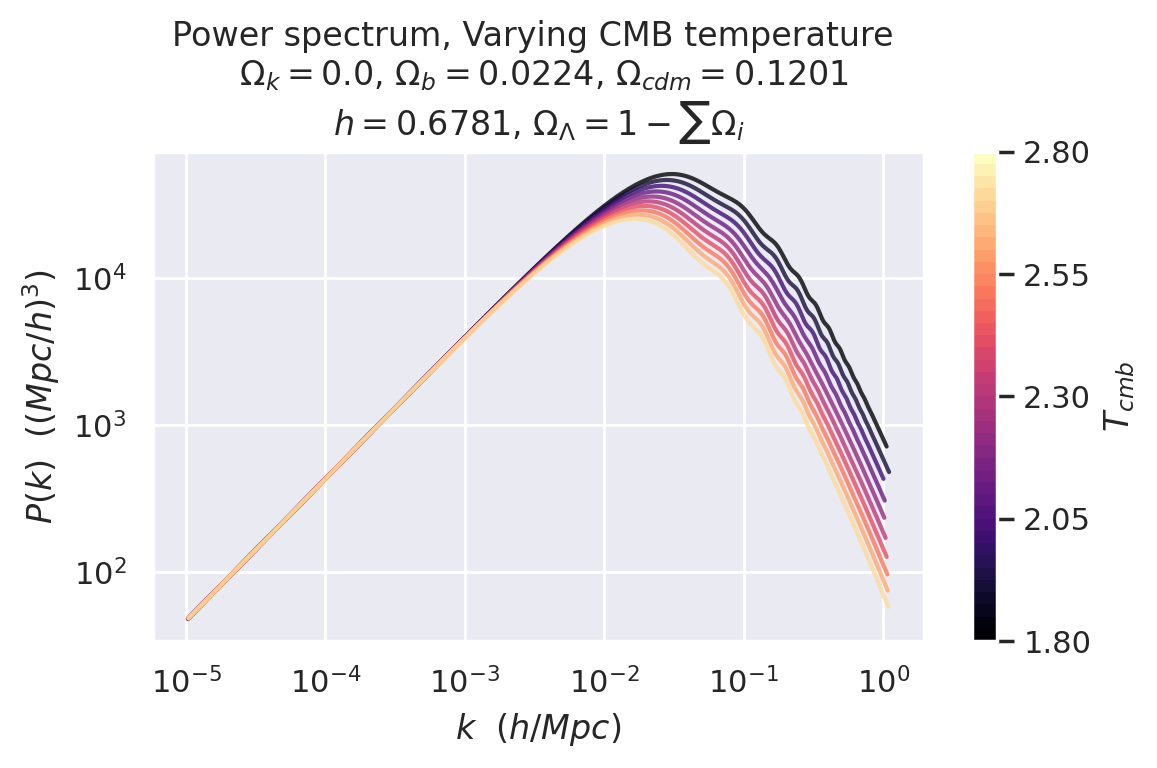

MovieWriter imagemagick unavailable; using Pillow instead.


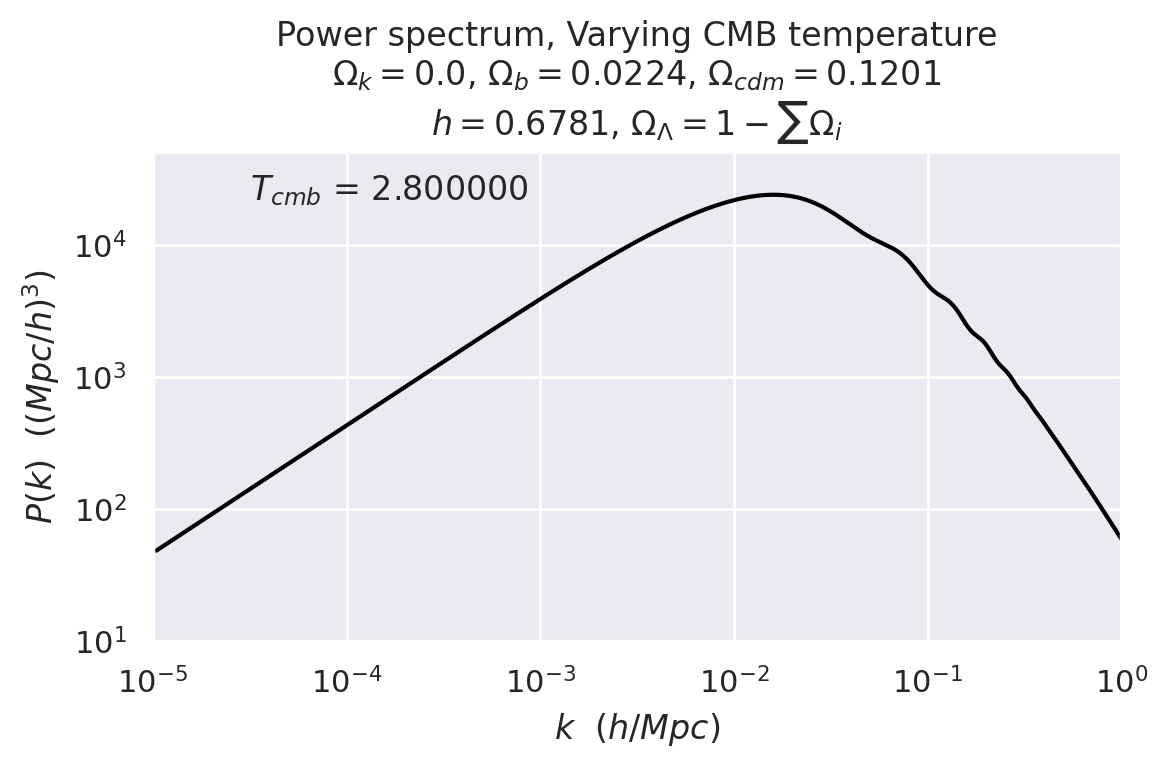

In [4]:
# Cosmic Microwave Background temperature variation

T_cmb_space = np.linspace(start=1.8, stop=2.8, num=40)

for i, T in enumerate(T_cmb_space):
    # Create new file
    filename = f'default_Tcmb_{i}.ini'
    modify_data(data=lines, filename=filename, T_cmb=T)

    # Run CLASS
    subprocess.call(['./class', f'default_Tcmb_{i}.ini'])

dataset = get_family_data('default_Tcmb_', n=len(T_cmb_space))
dataset = np.array(dataset)

graph(data=dataset, vals=T_cmb_space, val_name='$T_{cmb}$', scale='log',
      title='Power spectrum, Varying CMB temperature \n $\Omega_k = 0.0$,' +
      ' $\Omega_b = 0.0224$, $\Omega_{cdm} = 0.1201$\n$h = 0.6781$,' +
      ' $\Omega_{\Lambda} = 1 - \sum \Omega_i$',
      xlabel='$k$', ylabel='$P(k)$', save='../images/Tcmb.png')

animation(data=dataset, vals=T_cmb_space, val_name='$T_{cmb}$', scale='log',
          title='Power spectrum, Varying CMB temperature\n$\Omega_k = 0.0$,' +
          ' $\Omega_b = 0.0224$, $\Omega_{cdm} = 0.1201$\n$h = 0.6781$,' +
          ' $\Omega_{\Lambda} = 1 - \sum \Omega_i$',
          xlabel='$k$', ylabel='$P(k)$', filename='../images/Tcmb.gif')


/tmp/ipykernel_3587/3339786647.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(dataset)
/tmp/ipykernel_3587/2598648479.py:93: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sm, ticks=np.linspace(min(vals), max(vals), 5),


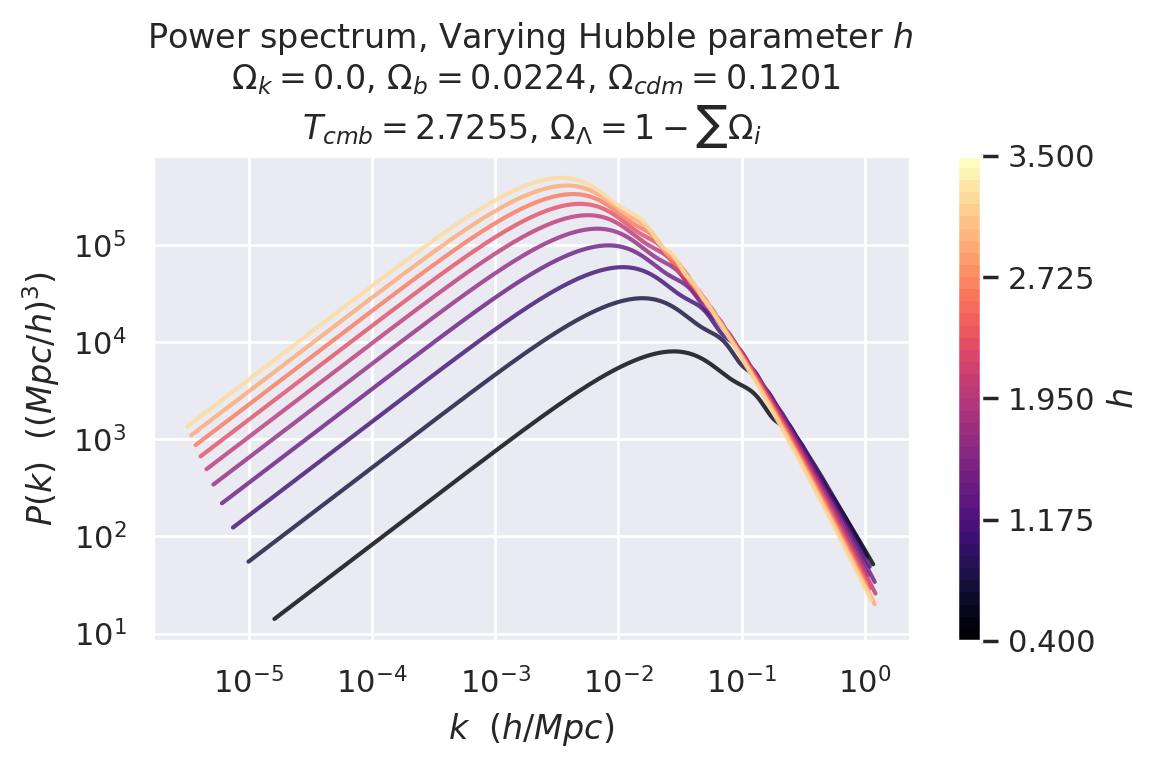

MovieWriter imagemagick unavailable; using Pillow instead.


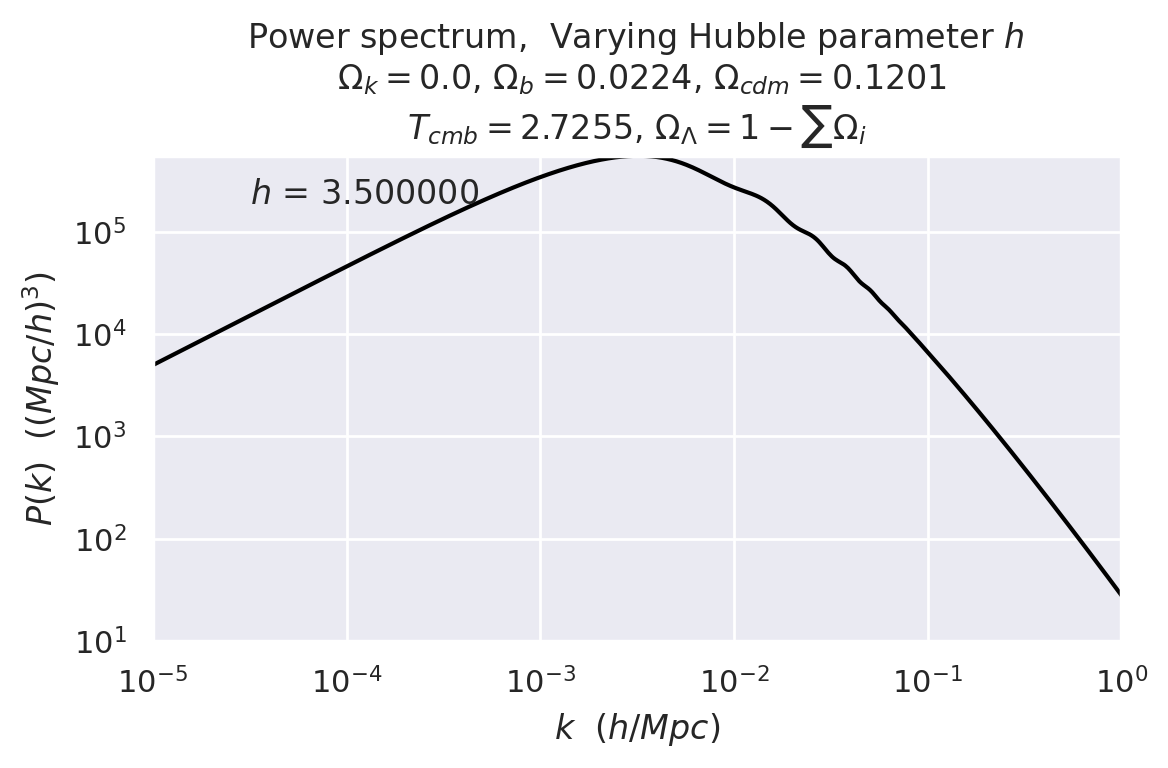

In [5]:
# Hubble parameter variation

h_space = np.linspace(start=0.4, stop=3.5, num=40)

for i, h in enumerate(h_space):
    # Create new file
    filename = f'default_h_{i}.ini'
    modify_data(data=lines, filename=filename, h=h)

    # Run CLASS
    subprocess.call(['./class', f'default_h_{i}.ini'])

dataset = get_family_data('default_h_', n=len(h_space))
dataset = np.array(dataset)

graph(data=dataset, vals=h_space, val_name='$h$', scale='log',
      title='Power spectrum, Varying Hubble parameter $h$ \n $\Omega_k = 0.0$,' +
      ' $\Omega_b = 0.0224$, $\Omega_{cdm} = 0.1201$\n$T_{cmb} = 2.7255$,' +
      ' $\Omega_{\Lambda} = 1 - \sum \Omega_i$',
      xlabel='$k$', ylabel='$P(k)$', save='../images/h.png')

animation(data=dataset, vals=h_space, val_name='$h$', scale='log',
          title='Power spectrum,  Varying Hubble parameter $h$ \n $\Omega_k = 0.0$,' +
          ' $\Omega_b = 0.0224$, $\Omega_{cdm} = 0.1201$\n$T_{cmb} = 2.7255$,' +
          ' $\Omega_{\Lambda} = 1 - \sum \Omega_i$',
          xlabel='$k$', ylabel='$P(k)$', filename='../images/h.gif')


/tmp/ipykernel_3587/375533920.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(dataset)
/tmp/ipykernel_3587/2598648479.py:93: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sm, ticks=np.linspace(min(vals), max(vals), 5),


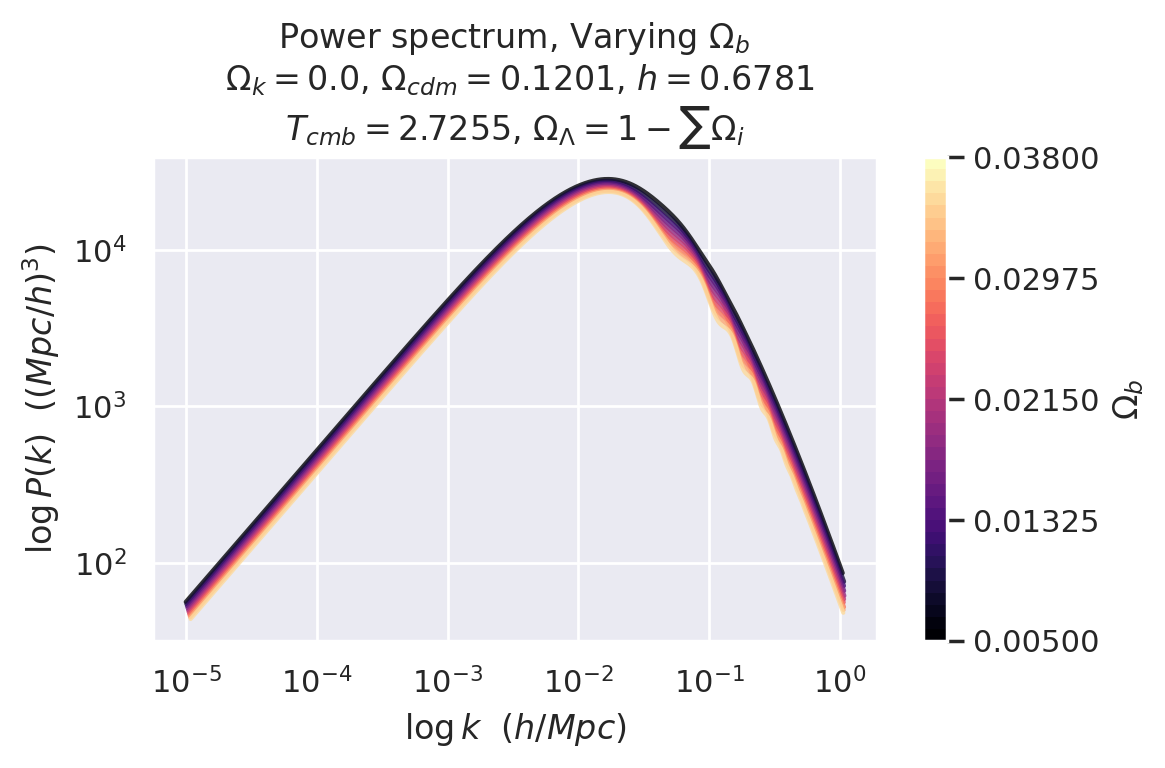

MovieWriter imagemagick unavailable; using Pillow instead.


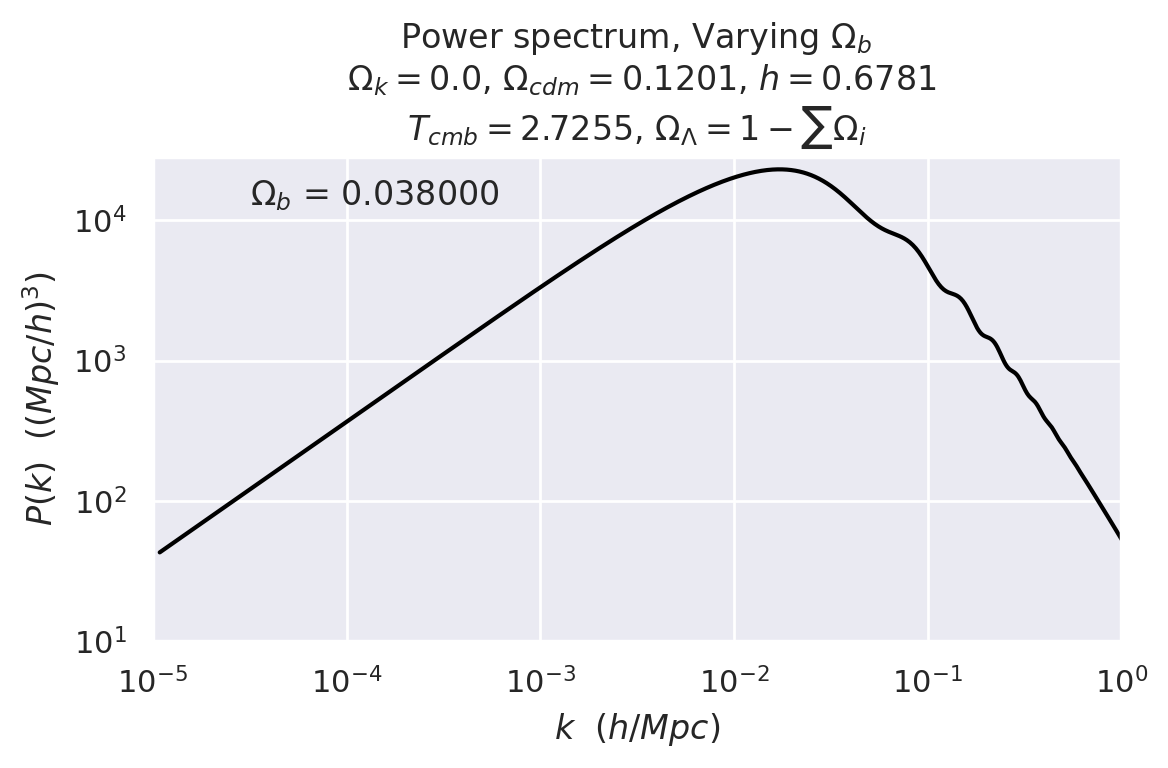

In [6]:
# Omega of baryons variation

omega_b_space = np.linspace(start=0.005, stop=0.038, num=40)

for i, omega_b in enumerate(omega_b_space):
    # Create new file
    filename = f'default_omega_b_{i}.ini'
    modify_data(data=lines, filename=filename, omega_b=omega_b)

    # Run CLASS
    subprocess.call(['./class', f'default_omega_b_{i}.ini'])

# Get data
dataset = get_family_data('default_omega_b_', n=len(omega_b_space))
dataset = np.array(dataset)

graph(data=dataset, vals=omega_b_space, val_name='$\Omega_b$', scale='log',
      title='Power spectrum, Varying $\Omega_b$ \n $\Omega_k = 0.0$,' +
      ' $\Omega_{cdm} = 0.1201$, $h = 0.6781$\n' +
      '$T_{cmb} = 2.7255$, $\Omega_{\Lambda} = 1 - \sum \Omega_i$',
      xlabel='$\log k$', ylabel='$\log P(k)$', save='../images/omega_b.png')

animation(data=dataset, vals=omega_b_space, val_name='$\Omega_b$', scale='log',
          title='Power spectrum, Varying $\Omega_b$ \n $\Omega_k = 0.0$,' +
          ' $\Omega_{cdm} = 0.1201$, $h = 0.6781$\n' +
          '$T_{cmb} = 2.7255$, $\Omega_{\Lambda} = 1 - \sum \Omega_i$',
          xlabel='$k$', ylabel='$P(k)$', filename='../images/omega_b.gif')


/tmp/ipykernel_3587/1657151846.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(dataset)
/tmp/ipykernel_3587/2598648479.py:93: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sm, ticks=np.linspace(min(vals), max(vals), 5),


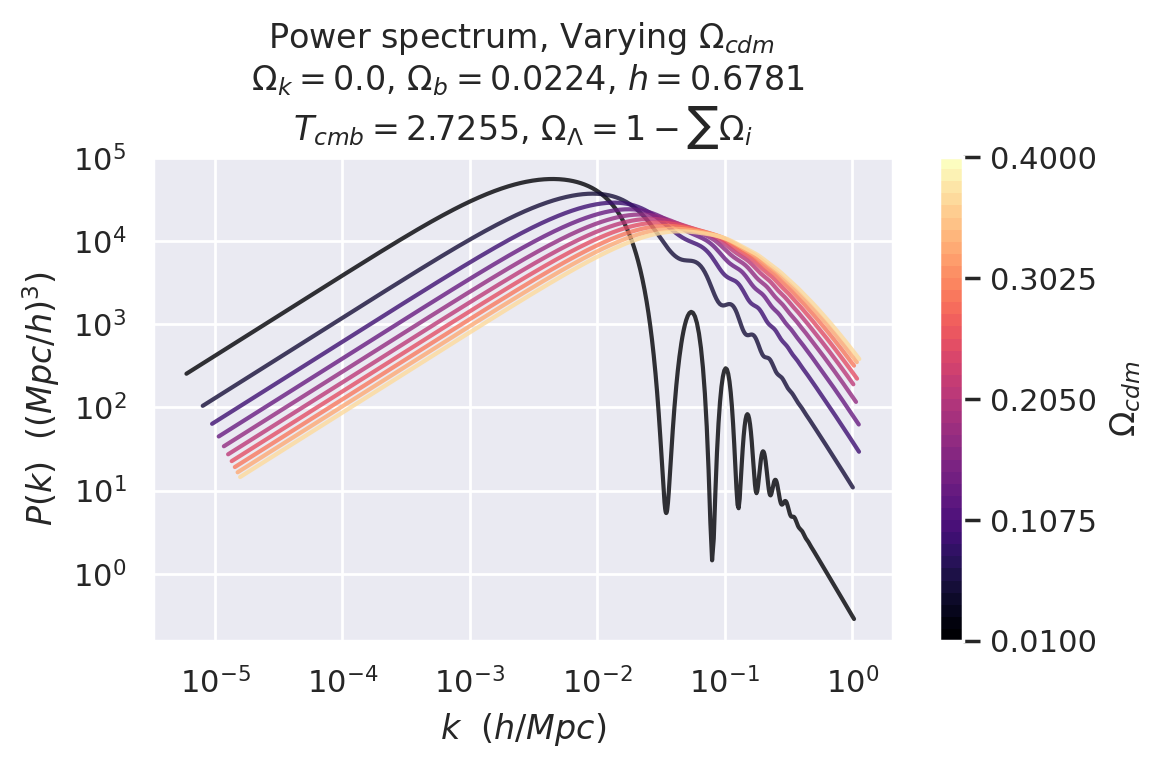

MovieWriter imagemagick unavailable; using Pillow instead.


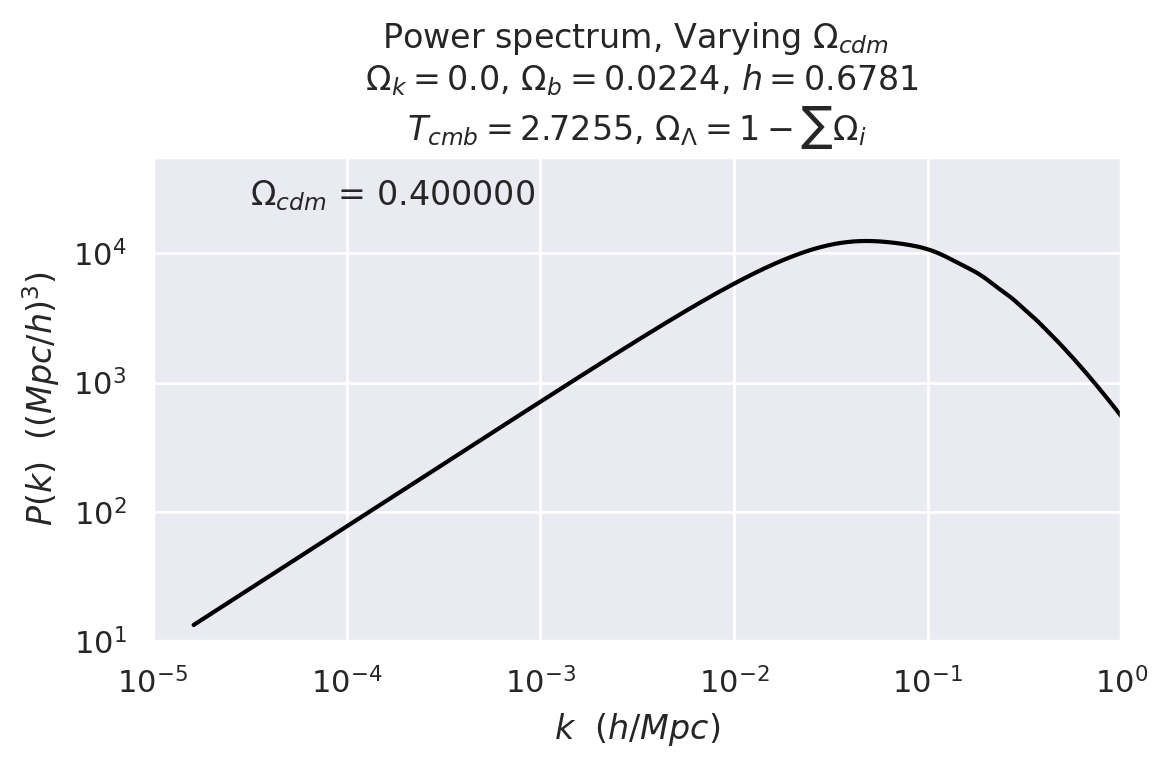

In [7]:
# Omega of cold dark matter variation

omega_cdm_space = np.linspace(start=0.01, stop=0.4, num=40)

for i, omega_cdm in enumerate(omega_cdm_space):
    # Create new file
    filename = f'default_omega_cdm_{i}.ini'
    modify_data(data=lines, filename=filename, omega_cdm=omega_cdm)

    # Run CLASS
    subprocess.call(['./class', f'default_omega_cdm_{i}.ini'])

dataset = get_family_data('default_omega_cdm_', n=len(omega_cdm_space))
dataset = np.array(dataset)

graph(data=dataset, vals=omega_cdm_space, val_name='$\Omega_{cdm}$', scale='log',
      title='Power spectrum, Varying $\Omega_{cdm}$ \n $\Omega_k = 0.0$,' +
      ' $\Omega_b = 0.0224$, $h = 0.6781$\n' +
      '$T_{cmb} = 2.7255$, $\Omega_{\Lambda} = 1 - \sum \Omega_i$',
      xlabel='$k$', ylabel='$P(k)$', save='../images/omega_cdm.png')

animation(data=dataset, vals=omega_cdm_space, val_name='$\Omega_{cdm}$', scale='log',
          title='Power spectrum, Varying $\Omega_{cdm}$ \n $\Omega_k = 0.0$,' +
          ' $\Omega_b = 0.0224$, $h = 0.6781$\n' +
          '$T_{cmb} = 2.7255$, $\Omega_{\Lambda} = 1 - \sum \Omega_i$',
          xlabel='$k$', ylabel='$P(k)$', filename='../images/omega_cdm.gif')


/tmp/ipykernel_3587/1734146227.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(dataset)
/tmp/ipykernel_3587/2598648479.py:93: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sm, ticks=np.linspace(min(vals), max(vals), 5),


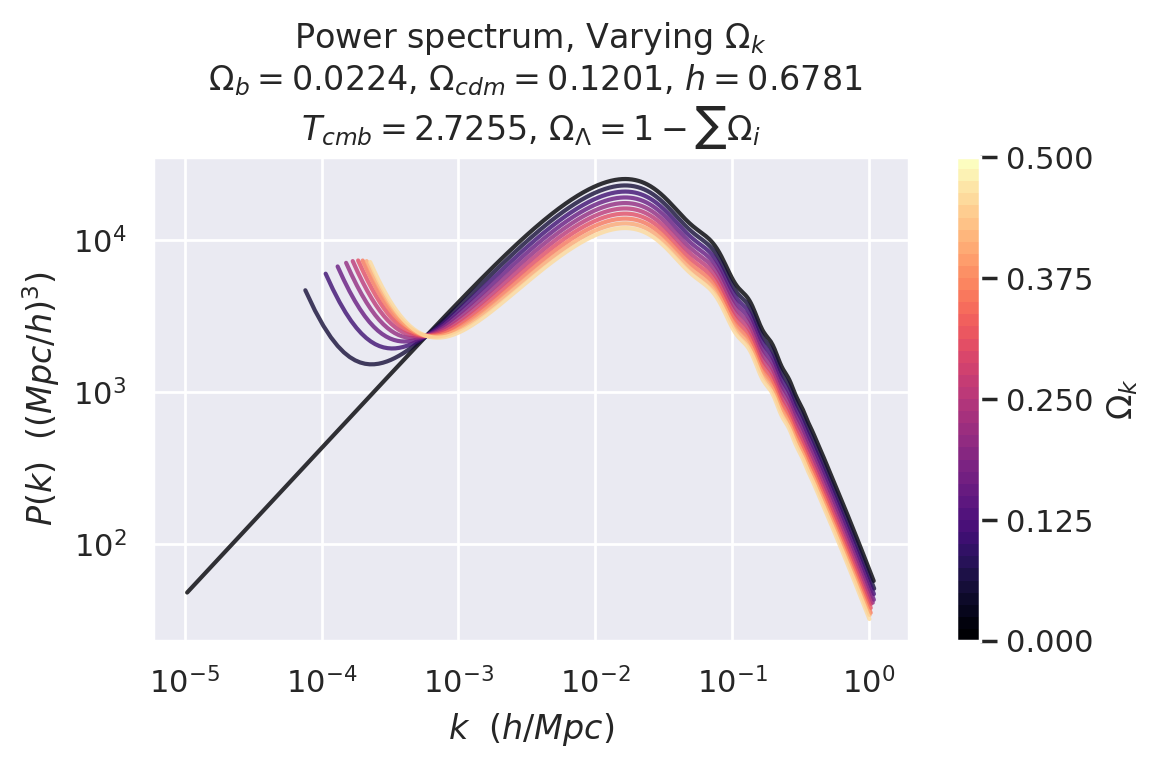

MovieWriter imagemagick unavailable; using Pillow instead.


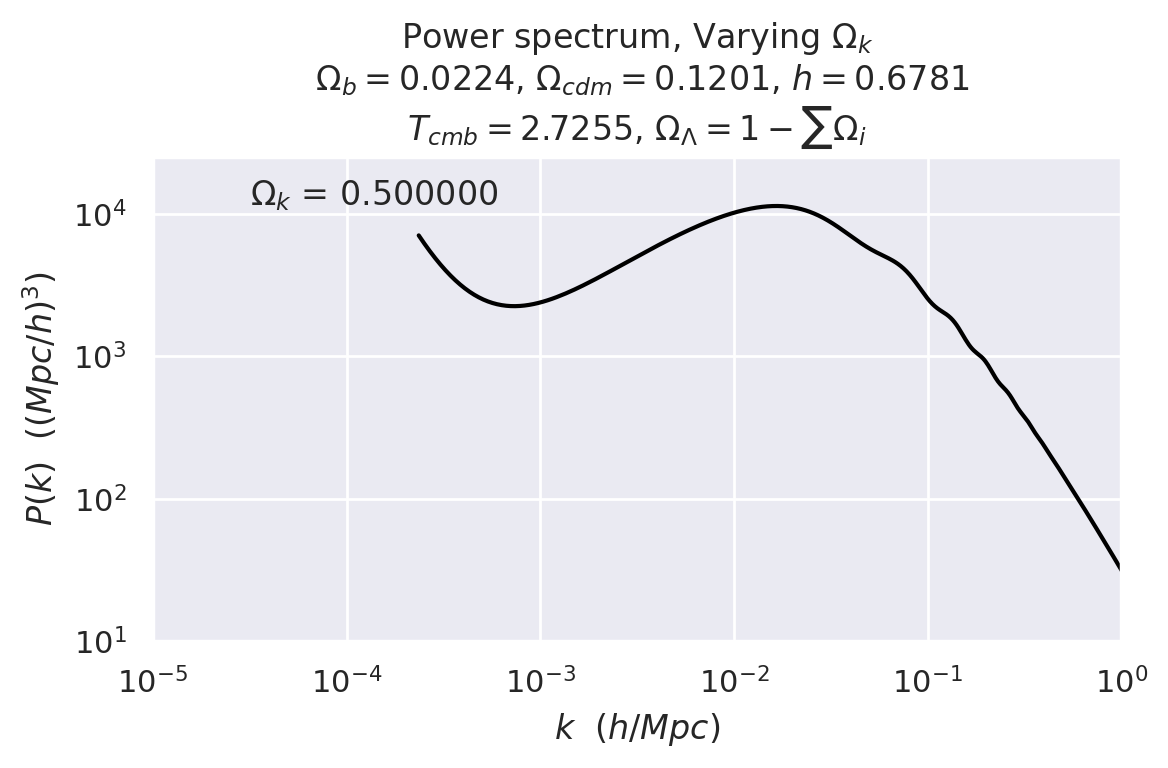

In [8]:
# Omega of curvature variation

omega_k_space = np.linspace(start=0.0, stop=0.5, num=40)

for i, omega_k in enumerate(omega_k_space):
    # Create new file
    filename = f'default_omega_k_{i}.ini'
    modify_data(data=lines, filename=filename, omega_k=omega_k)

    # Run CLASS
    subprocess.call(['./class', f'default_omega_k_{i}.ini'])

# Get data
dataset = get_family_data('default_omega_k_', n=len(omega_k_space))
dataset = np.array(dataset)

graph(data=dataset, vals=omega_k_space, val_name='$\Omega_k$', scale='log',
      title='Power spectrum, Varying $\Omega_k$ \n $\Omega_b = 0.0224$,' +
      ' $\Omega_{cdm} = 0.1201$, $h = 0.6781$\n' +
      '$T_{cmb} = 2.7255$, $\Omega_{\Lambda} = 1 - \sum \Omega_i$',
      xlabel='$k$', ylabel='$P(k)$', save='../images/omega_k.png')

animation(data=dataset, vals=omega_k_space, val_name='$\Omega_k$', scale='log',
          title='Power spectrum, Varying $\Omega_k$ \n $\Omega_b = 0.0224$,' +
          ' $\Omega_{cdm} = 0.1201$, $h = 0.6781$\n' +
          '$T_{cmb} = 2.7255$, $\Omega_{\Lambda} = 1 - \sum \Omega_i$',
          xlabel='$k$', ylabel='$P(k)$', filename='../images/omega_k.gif')
